In [1]:
import os
import re

import scipy
import scipy.cluster.hierarchy as sch
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
DATA_DIR = '../../data/stability_paper_data/'

In [3]:
FULL_FEATURES_FILENAME = 'augmented sample.xlsx'
CONTINUOUS_FEATURES_FILENAME = 'continousproperty.xlsx'
DISCRETE_FEATURES_FILENAME = 'discrictproperty.xlsx'

In [4]:
DROP_COLS = [
    'Material Composition',
]

TARGET_COLS = [
    'EnergyAboveHull',
    'Formation_energy',
]
TARGET_OF_INTEREST = 'EnergyAboveHull'

ADDITIONAL_CONTINUOUS_VARS = [
    'A_B',
    'A_O',
    'B_O',
    'goldschmidt_TF',
    'goldschmidt_TF_ionic',
    'num_of_atoms',
    'numberofelements',
    'octahedral_factor',
    'octahedral_factor_ionic',
    'shannon_radii'
]

In [5]:
full_df = pd.read_excel(os.path.join(DATA_DIR, FULL_FEATURES_FILENAME),
                        sheet_name='Sheet1', 
                        index_col=0)

In [7]:
target_df = full_df[TARGET_COLS]
target_series = target_df[TARGET_OF_INTEREST]
target_series_discrete = (target_series <= 40).astype(int)

full_df = full_df.drop(TARGET_COLS + DROP_COLS, axis=1)

In [10]:
# full_df.shape

# full_df.isna().sum().sum()

The author has provided a dataset of 1929 Perovskite compounds with 962 features.
Since this is a large count of features, through the EDA we aim to remove uninformative features, and also highlight the most informative features in predicting the stability.

### 1. Variable Scoping

#### (a) Separate Continuous vs. Discrete Variables
Since some of the algorithms used for modeling will need distinguishment of continuous vs. discrete variables, we separate the variable types here. We try to go with the author's intention as much as possible in deciding this, through the continuous and discrete variables mentioned in the code repository (https://github.com/uw-cmg/perovskite-oxide-stability-prediction) prepared by the author.

In [11]:
continuous_ref_df = pd.read_excel(os.path.join(DATA_DIR, CONTINUOUS_FEATURES_FILENAME)).drop('Symbol', axis=1)
discrete_ref_df = pd.read_excel(os.path.join(DATA_DIR, DISCRETE_FEATURES_FILENAME)).drop('Symbol', axis=1)

continuous_ref_cols = set([c.strip() for c in continuous_ref_df.columns])
discrete_ref_cols = set([c.strip() for c in discrete_ref_df.columns])

In [12]:
def normalize_column_name(col_name):
    col_name = re.sub(
        '^(host_Asite0_)|(host_Bsite0_)|(Asite_)|(Bsite_)', '', col_name)
    col_name = re.sub('\.1$', '', col_name)
    col_name = re.sub('(_host_Asite0)|(_host_Bsite0)$', '', col_name)
    col_name = re.sub(
        '(_max)|(_min)|(_weighted_avg)|(_range)|(_AB_avg)|(_AB_diff)|(_AB_ratio)$', '', col_name)
    return col_name.strip()

def is_weighted_avg_column(col_name):
    
    regex_search = re.search('_weighted_avg$', col_name)
    if regex_search is None:
        return False
    else:
        return True

In [13]:
# sanity check

all_cols = list(np.unique([normalize_column_name(c) for c in full_df.columns.values]))
assert len(
    set(all_cols) - set(continuous_ref_cols) - 
    set(discrete_ref_cols) - set(ADDITIONAL_CONTINUOUS_VARS)) == 0

In [14]:
continuous_cols = []
discrete_cols = []

for c in full_df.columns:
    normalized_name = normalize_column_name(c)
    
    if normalized_name in continuous_ref_cols | set(ADDITIONAL_CONTINUOUS_VARS):
        continuous_cols.append(c)
    elif is_weighted_avg_column(c):
        continuous_cols.append(c)
    elif normalized_name in discrete_ref_cols:
        discrete_cols.append(c)
    else:
        raise ValueError('unexpected column: {}'.format(c))

In [15]:
continuous_df = full_df[continuous_cols]
discrete_df = full_df[discrete_cols]

In [16]:
continuous_df.shape, discrete_df.shape

((2138, 616), (2138, 346))

#### (b) Remove Variables with Minimal Variance
There are some features that have minimal variance, which would be uninformative. 
We use a threshold of 1e-5 in standard deviation to remove these features.

In [17]:
def get_cols_below_std_threshold(df, threshold=1e-5):
    std = df.std(axis=0)
    return std[std < threshold].index.values

In [18]:
continuous_cols_to_drop = get_cols_below_std_threshold(continuous_df)
discrete_cols_to_drop = get_cols_below_std_threshold(discrete_df)

In [19]:
continuous_df = continuous_df.drop(continuous_cols_to_drop, axis=1)
discrete_df = discrete_df.drop(discrete_cols_to_drop, axis=1)

In [20]:
continuous_df.shape, discrete_df.shape

((2138, 574), (2138, 217))

#### (c) Remove Redundant Variables
Since the author has created derived features combining the element properties of A site / B site with their min / max / average, etc., it is highly likely that these features contain redundant information. To determine the clusters of features that contain redundant information, we run a hierarchical clustering on the feature correlation matrix, with threshold set to 90% (only pairwise correlations above 90% can be considered as a candidate to belong to same cluster). 
Once we have determined these cluster blocks, there are many ways to represent the feature block for modeling purpose - such as extracting components through PCA, using average of the features, etc. For EDA, we just pick one feature from each cluster block and remove all other redundant features from the block.
<br>
After removing redundant variables, we are left with 314 continuous variables and 123 discrete variables.

In [21]:
def get_cluster_infos(df, threshold=0.90):
    """Run hierarchical clustering of features based on correlation matrix"""
    pdist = sch.distance.pdist(df.values.T, metric='correlation')
    linkage = sch.linkage(pdist, method='complete')
    cluster_idxes = sch.fcluster(linkage, 1 - threshold, 'distance')
    
    cluster_idx_min = cluster_idxes.min()
    cluster_idx_max = cluster_idxes.max()
    
    df_cols = df.columns.values
    cluster_infos = []
    for c in range(cluster_idx_min, cluster_idx_max + 1):
        idxes_for_cluster = np.nonzero(cluster_idxes == c)[0]
        if len(idxes_for_cluster) >= 2:
            cluster_cols = df_cols[idxes_for_cluster]
            representative_col = cluster_cols[0]
            cluster_infos.append({
                'cluster_cols': cluster_cols,
                'representative_col': representative_col,
            })
    
    return cluster_infos


def remove_redundant_cols(df, cluster_infos):
    df_small = df.copy()
    
    for info in cluster_infos:
        cols_to_remove = list(set(info['cluster_cols']) - set([info['representative_col']]))
        df_small = df_small.drop(cols_to_remove, axis=1)
    
    return df_small.copy()

In [22]:
continuous_feature_cluster_infos = get_cluster_infos(continuous_df)
continuous_df_small = remove_redundant_cols(continuous_df, continuous_feature_cluster_infos)

discrete_feature_cluster_infos = get_cluster_infos(discrete_df)
discrete_df_small = remove_redundant_cols(discrete_df, discrete_feature_cluster_infos)

In [23]:
continuous_df.shape, continuous_df_small.shape

((2138, 574), (2138, 329))

In [24]:
discrete_df.shape, discrete_df_small.shape

((2138, 217), (2138, 122))

In [25]:
sample_cluster_cols = sorted(continuous_feature_cluster_infos, key=lambda x: -len(x['cluster_cols']))[0]['cluster_cols']

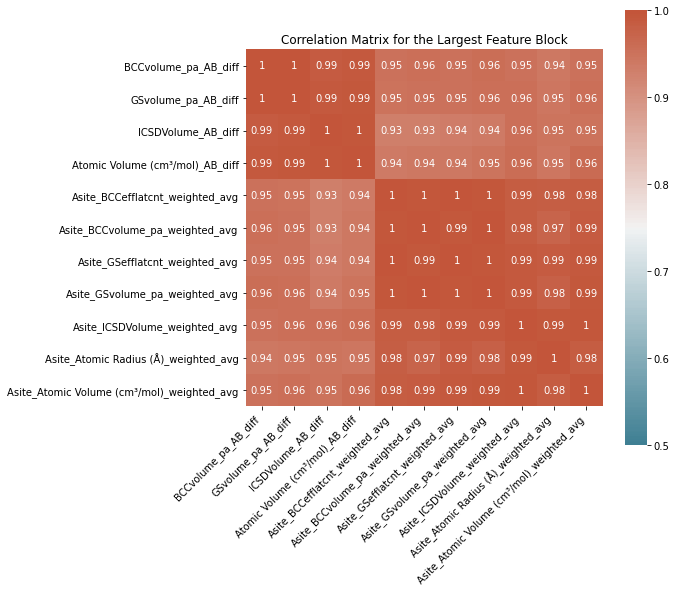

In [26]:
sample_corr = continuous_df[sample_cluster_cols].corr().round(3)

fig, ax = plt.subplots(figsize=(8, 8))

ax = sns.heatmap(
    sample_corr, 
    vmin=0.5, vmax=1, center=0.75,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    annot=True,
    ax=ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Correlation Matrix for the Largest Feature Block')
plt.show()

### 2. Determine Informative Features
Below, we perform a univariate analysis on feature's relationship to target, to gain insight for the most informative features. This would be beneficial in sanity checking the model result, but since it is a univariate analysis it may not coincide with the model result which could have interaction effects from multiple features.

#### (a) Continuous Variables
Here we look at the feature correlation vs. the Energy above convex hull to get insights of the most informative features. Through this analysis, it is suggested that the features **'HHIp_AB_avg', 'Asite_HHIr_min', 'Coeficient of Thermal Expansion (10^-6 K-1)_AB_avg', 'Asite_Coeficient of Thermal Expansion (10^-6 K-1)_max', 'Asite_ BP (K)_min'** would be the most informative. Although continuous variables, we can see that the min / max features below show very discrete values of features. Hence, it is likely that tree based models that can handle non-linear splits / groupings of these discrete intervals, would work better than linear models.

In [27]:
corr_matrix = pd.concat([continuous_df_small, target_series], axis=1).corr()

In [28]:
corr_to_target = corr_matrix[TARGET_OF_INTEREST].drop(TARGET_OF_INTEREST).to_frame('corr')
corr_to_target['abs_corr'] = corr_to_target['corr'].abs()
corr_to_target = corr_to_target.sort_values('abs_corr', ascending=False)

In [29]:
corr_to_target = corr_to_target.round(3)

In [30]:
# corr_to_target.head(5).index.values

In [31]:
print('Top continuous features determined by correlation')
corr_to_target[['corr']].head(5)

Top continuous features determined by correlation


,corr
Asite_HHIr_min,-0.490
Coeficient of Thermal Expansion (10^-6 K-1)_AB_avg,0.488
HHIp_AB_avg,-0.487
Asite_Coeficient of Thermal Expansion (10^-6 K-1)_max,0.476
Bsite_IsFCC_weighted_avg,0.464


In [32]:
top_continuous_features = corr_to_target.head(5).index.values
continuous_with_target = pd.concat([continuous_df_small, target_series], axis=1)

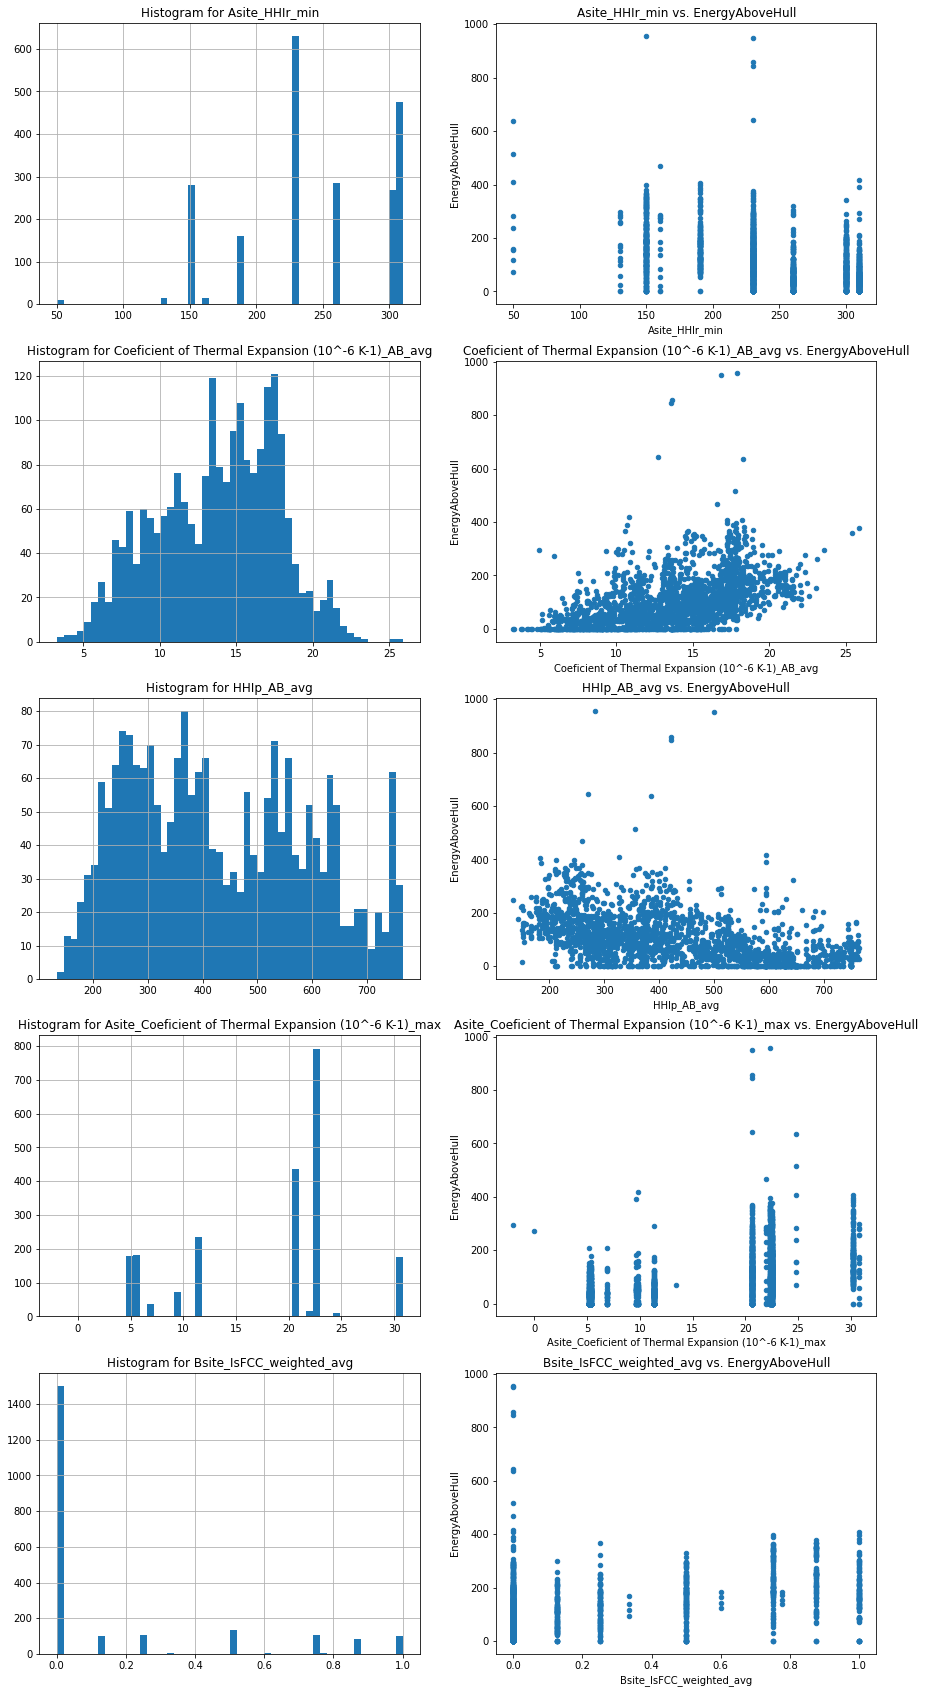

In [33]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 30))

for i, feature in enumerate(top_continuous_features):
    continuous_df_small[feature].hist(bins=50, ax=axes[i, 0])
    axes[i, 0].set_title('Histogram for {}'.format(feature))

    continuous_with_target.plot(kind='scatter', 
                                x=feature, 
                                y=TARGET_OF_INTEREST,
                                title='{} vs. {}'.format(feature, TARGET_OF_INTEREST),
                                ax=axes[i, 1])

plt.savefig('fig1_v2.png')

#### (b) Discrete Variables
Here we look at the mutual information gain from the feature and the stability binary variable to get insights of the most informative features. We use the same criteria as author of Energy above convex hull being under 40meV/atom to determine stability of the compound. Through this analysis, it is suggested that the features **'Bsite_At. #_min', 'host_Bsite0_At. #', 'host_Bsite0_Group',
       'host_Bsite0_NUnfilled', 'Asite_At. #_min'** would be the most informative discrete variables. 
From the box plots we can see that these features do seem quite useful, as depending on the value the range of energy above convex hull is quite different.

In [34]:
le = LabelEncoder()

discrete_df_small_transform = np.zeros_like(discrete_df_small.values, dtype=int)

for i in range(discrete_df_small.shape[1]):
    discrete_df_small_transform[:, i] = le.fit_transform(discrete_df_small.values[:, i])

In [35]:
mutual_information_gains = mutual_info_classif(discrete_df_small_transform, 
                                               target_series_discrete, 
                                               discrete_features=True)

In [36]:
print('Top discrete features determined by mutual information gain')

mi_gain_df = pd.DataFrame({
    'feature': discrete_df_small.columns,
    'MI': mutual_information_gains,
}).sort_values('MI', ascending=False).round(3)

mi_gain_df.set_index('feature').head(5)

Top discrete features determined by mutual information gain


,MI
feature,
Bsite_At. #_min,0.123
host_Bsite0_At. #,0.117
host_Bsite0_Group,0.108
host_Bsite0_NUnfilled,0.103
Asite_At. #_min,0.102


In [37]:
top_discrete_features = mi_gain_df.head(5).feature.values
discrete_with_target = pd.concat([discrete_df_small, target_series], axis=1)

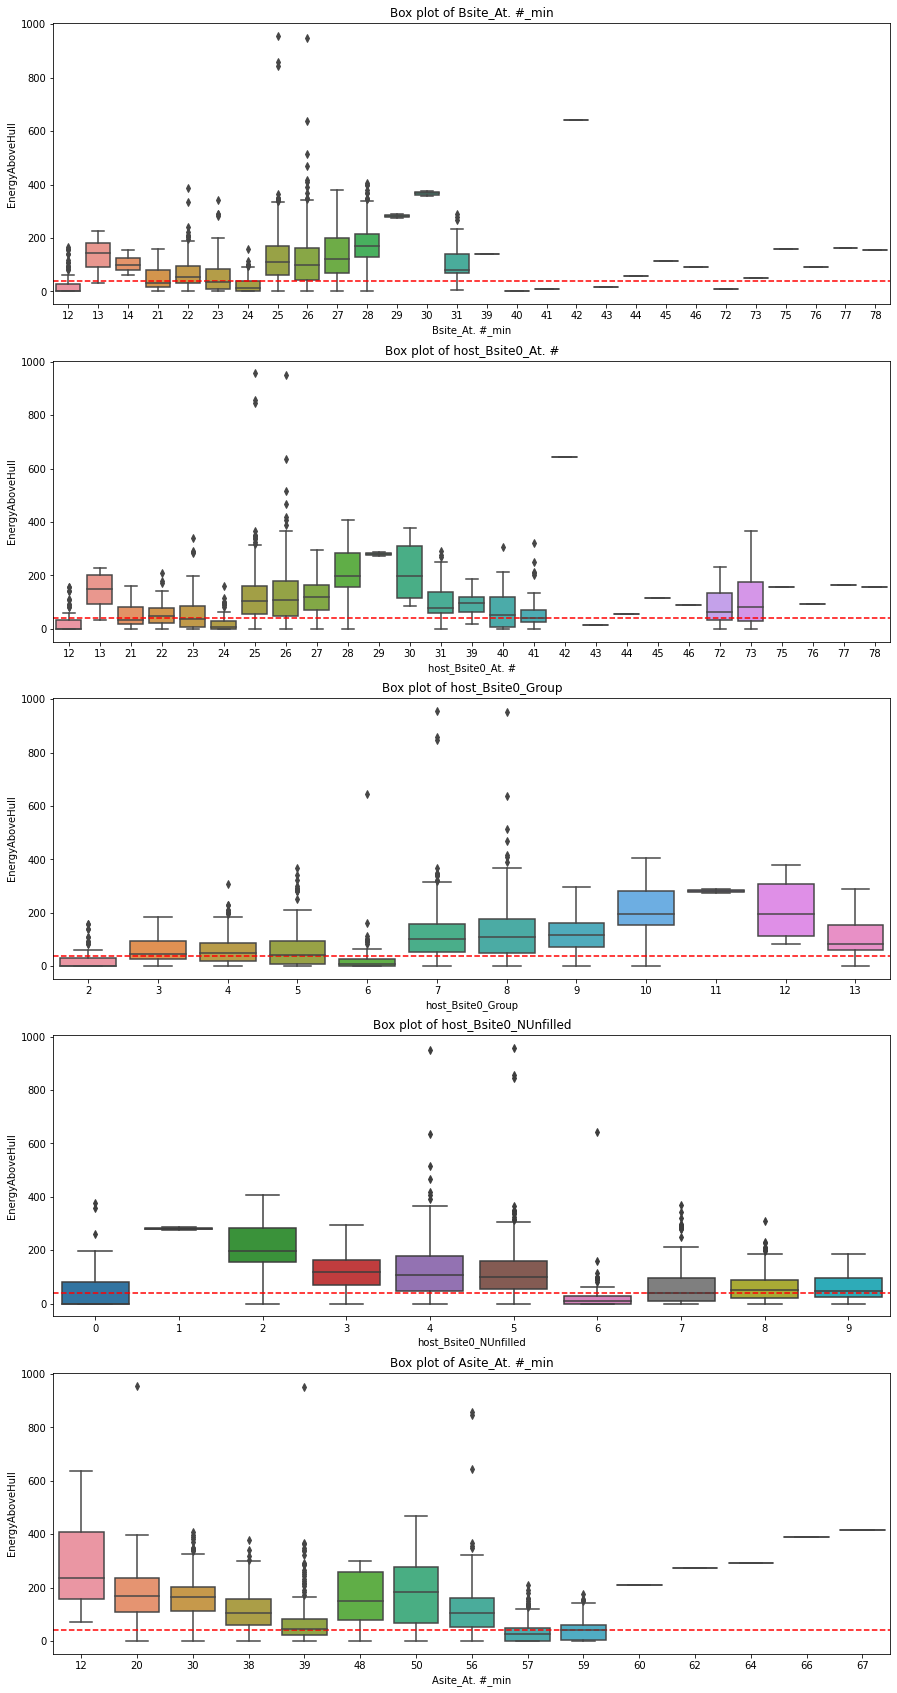

In [38]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 30))

for i, feature in enumerate(top_discrete_features):

    sns.boxplot(data=discrete_with_target, 
                x=feature, 
                y=TARGET_OF_INTEREST, 
                ax=axes[i]).set_title('Box plot of {}'.format(feature))
    
    axes[i].axhline(y=40, c='r', linestyle='--')
    
plt.savefig('fig2_v2.png')